Sujet 2 — Classification avec SVM sur le dataset IRIS
=====================================================
    realisee par : [DOHA AYAD ET YASSIR KARYM ]


Titre et objectifs:
# SVM pour la classification sur le dataset IRIS

Objectifs :
- Mettre en œuvre un SVM pour la classification.
- Préparer les données (standardisation, split train/test).
- Définir des métriques pertinentes et comparer à une baseline simple.
- Faire une recherche d’hyperparamètres (grille courte).
- Évaluer avec validation croisée.
- Discuter des limites du modèle.

Dataset utilisé : `sklearn.datasets.load_iris`.

1. Imports, seed, versions





In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)

import sklearn
import sys
import random

# Seed fixe pour la reproductibilité
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy: 2.0.2
pandas: 2.2.2
scikit-learn: 1.6.1


2.Chargement du dataset IRIS et premier aperçu

In [24]:
iris = datasets.load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Dimensions X:", X.shape)
print("Dimensions y:", y.shape)
print("Classes (indices):", np.unique(y))
print("Noms des classes:", target_names)

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

df.head()

Dimensions X: (150, 4)
Dimensions y: (150,)
Classes (indices): [0 1 2]
Noms des classes: ['setosa' 'versicolor' 'virginica']


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


3.Statistiques descriptives et valeurs manquantes

In [25]:
print("Résumé statistique des features :")
display(df.describe())

print("\nValeurs manquantes par colonne :")
print(df.isna().sum())

Résumé statistique des features :


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000



Valeurs manquantes par colonne :
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64


4.Visualisation pairplot

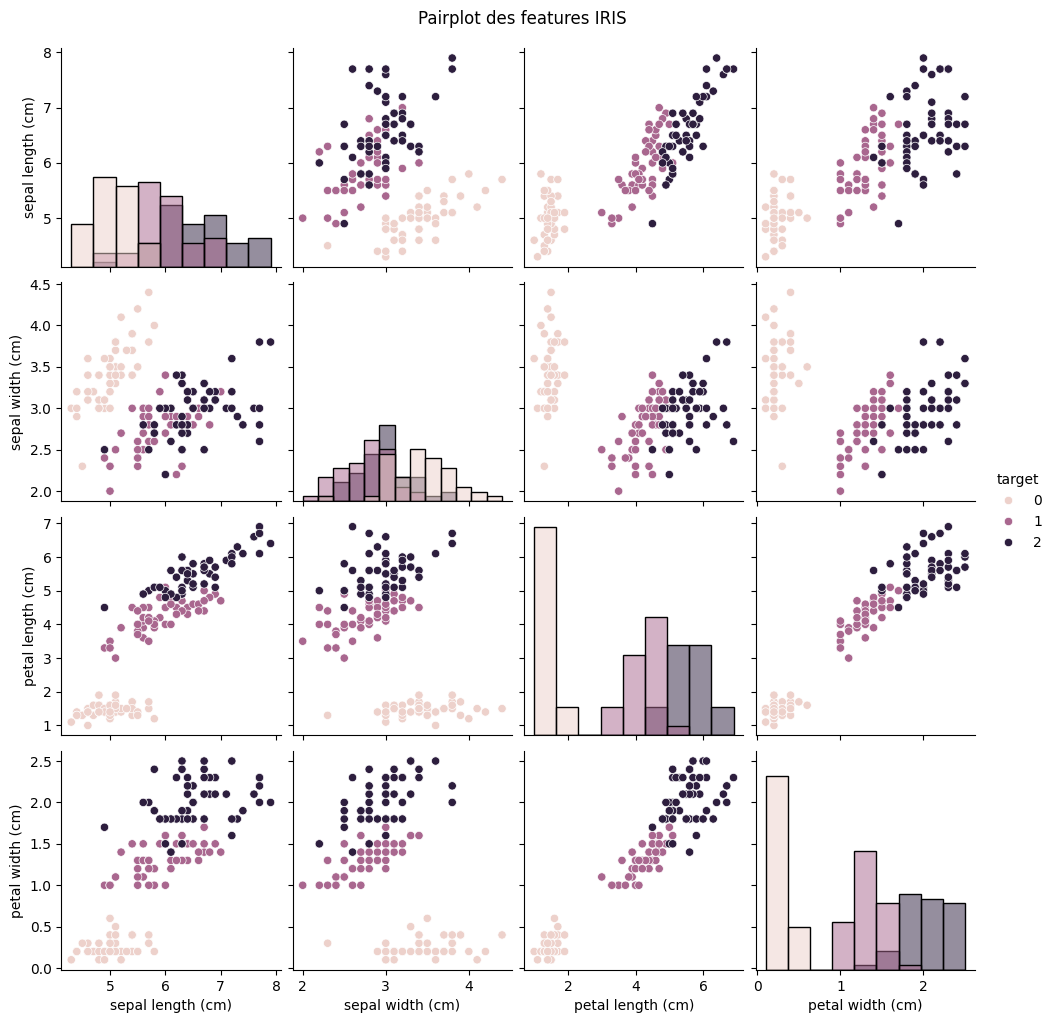

In [26]:
sns.pairplot(df, hue='target', diag_kind='hist')
plt.suptitle("Pairplot des features IRIS", y=1.02)
plt.show()

5.Commentaires exploration:
## Exploration rapide — Commentaires

- Aucune valeur manquante dans le dataset IRIS.
- 3 classes équilibrées (50 échantillons par classe).
- Certaines classes sont bien séparées dans l’espace des features, mais il existe un chevauchement (surtout versicolor / virginica).

6.Split train / test

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Taille train:", X_train.shape[0])
print("Taille test:", X_test.shape[0])

print("Répartition des classes dans le train:", np.bincount(y_train))
print("Répartition des classes dans le test:", np.bincount(y_test))

Taille train: 120
Taille test: 30
Répartition des classes dans le train: [40 40 40]
Répartition des classes dans le test: [10 10 10]


7.Baseline simple (classe majoritaire)

In [28]:
# Baseline : prédire toujours la classe majoritaire du train
(unique, counts) = np.unique(y_train, return_counts=True)
majority_class = unique[np.argmax(counts)]
print("Classe majoritaire (train):", majority_class, "->", target_names[majority_class])

y_pred_baseline = np.full_like(y_test, fill_value=majority_class)

baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1_macro = f1_score(y_test, y_pred_baseline, average='macro')

print("Baseline accuracy:", baseline_acc)
print("Baseline F1-macro:", baseline_f1_macro)

Classe majoritaire (train): 0 -> setosa
Baseline accuracy: 0.3333333333333333
Baseline F1-macro: 0.16666666666666666


8.Commentaire baseline:
## Baseline — Commentaires

La baseline choisie est un classifieur très simple qui prédit toujours la classe
majoritaire observée dans le jeu de train.

Elle permet de vérifier que le SVM apporte bien un gain significatif en termes
d'accuracy et de F1-score par rapport à une règle naïve.

9.Pipeline SVM + GridSearchCV

In [29]:
pipe_svm = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=SEED))
])

param_grid = {
    "svm__C": [0.1, 1, 10, 100],
    "svm__kernel": ["linear", "rbf"],
    "svm__gamma": ["scale", 0.01, 0.1]
}

grid_search = GridSearchCV(
    estimator=pipe_svm,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score F1-macro (CV):", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Meilleurs hyperparamètres: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Meilleur score F1-macro (CV): 0.9749019607843138


10.Résultats détaillés de la grille

In [30]:
cv_results = pd.DataFrame(grid_search.cv_results_)

cols_to_show = [
    "params",
    "mean_test_score",
    "std_test_score",
    "mean_fit_time"
]

cv_results_sorted = cv_results[cols_to_show].sort_values("mean_test_score", ascending=False)
cv_results_sorted.head(10)

,params,mean_test_score,std_test_score,mean_fit_time
6,"{'svm__C': 1, 'svm__gamma': 'scale', 'svm__ker...",0.974902,0.020492,0.004992
8,"{'svm__C': 1, 'svm__gamma': 0.01, 'svm__kernel...",0.974902,0.020492,0.006054
10,"{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel'...",0.974902,0.020492,0.005636
0,"{'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__k...",0.974703,0.033813,0.006425
15,"{'svm__C': 10, 'svm__gamma': 0.01, 'svm__kerne...",0.974703,0.033813,0.006789
11,"{'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel'...",0.974703,0.033813,0.006184
4,"{'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kerne...",0.974703,0.033813,0.006286
2,"{'svm__C': 0.1, 'svm__gamma': 0.01, 'svm__kern...",0.974703,0.033813,0.005414
21,"{'svm__C': 100, 'svm__gamma': 0.01, 'svm__kern...",0.966601,0.031198,0.005642
23,"{'svm__C': 100, 'svm__gamma': 0.1, 'svm__kerne...",0.966536,0.016732,0.005729


11.Évaluation sur le test set

In [31]:
best_model = grid_search.best_estimator_

y_pred_test = best_model.predict(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro')

print("Test accuracy:", test_acc)
print("Test F1-macro:", test_f1_macro)
print("\nClassification report:\n")
print(classification_report(y_test, y_pred_test, target_names=target_names))

Test accuracy: 1.0
Test F1-macro: 1.0

Classification report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



12.Matrice de confusion

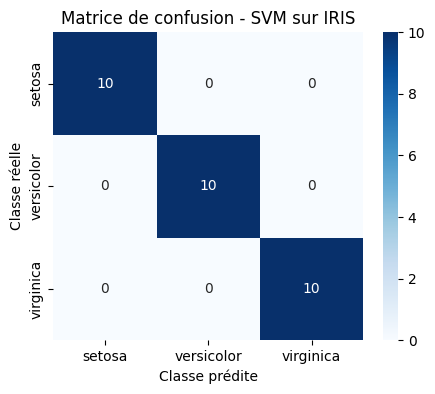

In [32]:
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion - SVM sur IRIS")
plt.show()

13.Courbes ROC multi-classe (one-vs-rest)

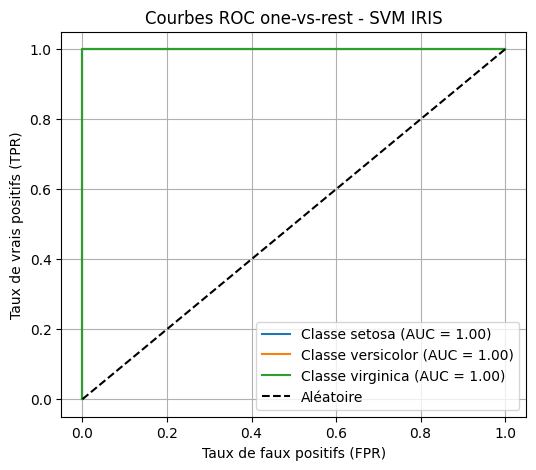

In [33]:
# Binarisation des labels pour ROC multi-classe (one-vs-rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

y_score = best_model.predict_proba(X_test)

plt.figure(figsize=(6,5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Classe {target_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--', label="Aléatoire")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC one-vs-rest - SVM IRIS")
plt.legend()
plt.grid(True)
plt.show()

14.Interprétation, limites et pistes d'amélioration:
## Interprétation des résultats

- **Baseline**  
  - La baseline qui prédit toujours la classe majoritaire obtient une accuracy et un F1-macro faibles.
  - Elle sert uniquement de point de comparaison naïf.

- **SVM**  
  - Le SVM, après recherche d'hyperparamètres par validation croisée (GridSearchCV, cv=5),
    atteint une accuracy et un F1-macro nettement supérieurs à la baseline.
  - Le rapport de classification montre de bons scores de précision et de rappel pour chaque classe.
  - La matrice de confusion permet de voir les classes les plus confondues
    (souvent versicolor et virginica sur IRIS).

- **Courbes ROC**  
  - Les courbes ROC one-vs-rest pour chaque classe montrent des AUC (aires sous la courbe)
    élevées, ce qui confirme la bonne capacité de discrimination du modèle.

## Limites de l'approche

- **Dataset IRIS**  
  - Petit (150 échantillons, 4 features), bien propre et peu bruité.
  - Les bonnes performances ne sont pas forcément représentatives de problèmes réels plus complexes.

- **SVM et hyperparamètres**  
  - Le SVM est sensible aux choix de `C`, du noyau (`kernel`) et de `gamma`.
  - Une grille plus large ou une recherche plus fine pourrait donner des résultats légèrement meilleurs,
    au prix d'un temps de calcul plus élevé.

- **Interprétabilité**  
  - Avec un noyau non linéaire comme RBF, les frontières de décision sont difficiles à interpréter.
  - On perd en lisibilité par rapport à des modèles plus simples (régression logistique, arbre de décision).

## Pistes d'amélioration

- Tester d'autres noyaux (`poly`) ou d'autres plages d'hyperparamètres.
- Comparer le SVM à d'autres modèles (RandomForest, k-NN, régression logistique) pour voir
  lequel est le plus adapté à ce dataset.
- Utiliser une validation croisée imbriquée (nested CV) pour estimer de manière plus robuste
  la performance généralisée.
- Appliquer la même méthodologie à un dataset plus difficile comme `load_breast_cancer`
  ou `load_digits` pour mieux voir les limites du SVM.